# Práctica 2: clasificación de dígitos MNIST mediante AdaBoost 
ELVI MIHAI SABAU SABAU | 51254875L

**Introducción**

Importar librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.datasets import mnist

Desde la libería de Keras podemos descargar la base datos MNIST




In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
x_train.shape,y_train.shape


((60000, 28, 28), (60000,))

Guardar base de datos en un fichero

In [4]:
np.savez("mnist",x=x_train,y=y_train)

Cargar base de datos desde un fichero

In [5]:
npzfile = np.load("mnist.npz")
mnist_X = npzfile['x']
mnist_Y = npzfile['y']
mnist_X.shape

(60000, 28, 28)

**Implementación AdaBoost**

Funciones auxiliares, de normalización, y adaptación de los datasets.


In [37]:
# Funcion para imprimir graficas rapidamente
def plot_arrays(X, Y, title, xlabel, ylabel):
    plt.title(title)
    plt.plot(X, Y, "bo")
    plt.xlabel(ylabel)
    plt.ylabel(xlabel)
    plt.show()

In [6]:
# Funcion para normalizar el conjunto de imagenes de vector 2D a 1D
def normalizar_conjunto(X, dim_imagen):
  return X.reshape(len(X), dim_imagen)

In [7]:
# El conjunto de entrenamiento para una clase ( tipo de imágen ) debe ser: 50% imágenes de la clase, y 50% imágenes que no son de la clase.
def generar_conjunto_entrenamiento(N, clase, x_train, y_train):

  # N: Total de imágenes del conjunto de entrenamiento, debe ser para para partir 50% / 50%
  if(N % 2 != 0):
    raise Exception("N no es Par")

  # Mitad de la clase, Mitad no clase.
  N = int(N/2)

  # Creamos una máscara para todo el conjunto de entrenamiento
  mask = y_train == clase

  # Partimos en 2 el dataset, los elementos que son de la clase, y los que no lo son.
  arr_clase = x_train[mask]
  arr_noClase = x_train[~mask]

  # Concatenamos dichos arrays de imagenes, y aparte creamos Y, un array de 1 y -1 por cada posicion de X dependiendo de su imagen.
  X = np.concatenate((arr_clase[0:N], arr_noClase[0:N]))
  X = normalizar_conjunto(X, 28 * 28)
 
  Y = np.concatenate((np.ones(N), np.ones(N) * -1))

  return (X, Y)

Funciones necesarias para los clasificadores débiles

In [8]:
# Dimensión con la que vamos a trabajar. En nuestro caso 28*28
def generar_clasificador_debil(dim_imagen):
  ht = np.zeros(3)
  ht[0] = np.random.randint(0, dim_imagen)     # Num. Pixel
  ht[1] = random.randint(0, 255)               # Valor Umbral Grises
  ht[2] = np.sign(np.random.rand(1) * 2-1)     # Valor del ubral, miramos por encima (1) o por debajo (-1).
  return ht;

In [9]:
def aplicar_clasificador_debil(ht, X):

  # Por cada imágen de X, comprobamos si el pixel de dicha imágen tiene un valor mayor que el clasificador
  #   si no lo es, en vez de descartarlo, le podemos dar la vuelta, y reusarlo.
  if(ht[2] == 1):
    mascara_resultados = X[:, int(ht[0])] > ht[1]
  else: 
    mascara_resultados = X[:, int(ht[0])] <= ht[1]

  # Usamos int para pasar de true y false a 1 y 0
  resultados = np.int16(mascara_resultados)
  
  # Pasamos de 0 a -1
  resultados[np.where(resultados == 0)] = -1

  return resultados

In [17]:
def obtener_error(resultados, Y, D):

  # -1 si no es, 1 si es, y con int64 pasamos los true y falses resultantes a 1 y 0
  errv = np.int64(resultados != Y)
  sumerr = np.float64(np.sum(errv * D))
  
  return [sumerr, errv]

In [34]:
def adaboost(X, Y, T, A):

  # Vector de error, se actualiza por cada clasificador debil, inicialmente uniforme
  D = np.ones(len(X), dtype=np.double) / len(X)

  # Datos para la gráfica.
  pixel = []
  error = []
  
  # Array donde guardaremos tuplas de [mejor_clasificador, confianza] = [ht, alpha]
  H = []

  for t in range(T):
    
    # Menor suma de errores del clasificador debil y su array de errores.
    menor_sumerr = np.inf
    menor_errv = []

    # Mejor clasificador debil ( de A pruebas aleatorias, el que menor error tiene )
    mejor_ht = None

    # Probamos A clasificadores debiles, y nos quedamos con el mejor de todos.
    for k in range(A):

      ht = generar_clasificador_debil(28 * 28)
      resultados_entrenamiento = aplicar_clasificador_debil(ht, X)
      [sumerr, errv] = obtener_error(resultados_entrenamiento, Y, D)
      
      if(sumerr < menor_sumerr):
        mejor_ht = ht
        menor_sumerr = sumerr
        menor_errv = errv

      """if(menor_sumerr > 0.45):
        A = A + 1"""

    # Calculamos la confianza.
    alpha = np.float64(0.5 * np.log2((1.0 - menor_sumerr) / menor_sumerr))

    # Arrays de clasificadores y sus confianzas.
    H.append([mejor_ht, alpha])

    # Recalculamos D y normalizamos.
    # print((alpha, menor_sumerr, np.sum(D)))
    Z = np.sum(D)
    exp = np.float64(np.exp(-alpha * -np.float64(menor_errv)))
    D = np.float64((D * exp) / Z)

    # Datos para gráfica.
    pixel.append(mejor_ht[0])
    error.append(menor_sumerr)

  # Un plot chulo de los mejores debiles
  plot_arrays(error, pixel, "Error de cada Clasificador por Pixel", "Grado de Error - 1: 100% error, 0: Perfecto.", "Numero de Pixel.")

  print("Clasificadores de T:")
  print(H)

  return H

Definimos una funcion para aplicar el clasificador fuerte a un conjunto de imágnes.

In [19]:
def aplicar_clasificador_fuerte(H, X):  
  certeza = []

  # Por cada clasificador debil ht del cojunto de fuertes h, lo aplicamos a todas las imágnes de X, y vemos si nos dice
  for [ht, alpha] in H:

    # POR CADA IMAGEN SE PASA TODAS LAS ht
    resultados = aplicar_clasificador_debil(ht, X)

    if (len(certeza) == 0):
      certeza = alpha * resultados
    else:
      certeza = certeza + (alpha * resultados)

  f = np.sign(certeza)
  return f

<hr>

<h1>Hito 1 - Entrenar para la clase "0"<h1>

Lanzar entrenamiento

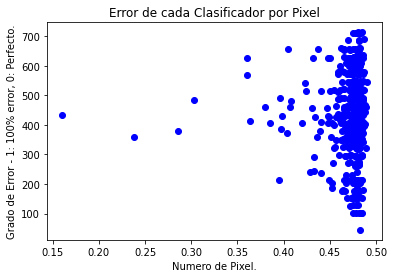

Clasificadores de T:
[[array([435.,  71.,  -1.]), 1.194014012418617], [array([358.,  20.,   1.]), 0.8374857038031446], [array([380.,  12.,  -1.]), 0.6592954522118886], [array([483.,  38.,   1.]), 0.5999942752649191], [array([627., 220.,   1.]), 0.41233670972148156], [array([569., 115.,   1.]), 0.4136011226534808], [array([407.,  45.,  -1.]), 0.3384885967842346], [array([414.,  15.,   1.]), 0.40245780721791874], [array([461.,  30.,  -1.]), 0.3531071005496669], [array([212., 189.,   1.]), 0.30691598402833353], [array([374., 162.,   1.]), 0.28090877204226083], [array([387.,  75.,   1.]), 0.3019740549420318], [array([656.,  63.,   1.]), 0.2772918438177432], [array([429.,  21.,   1.]), 0.2975195179603227], [array([461.,   2.,  -1.]), 0.27209971163743363], [array([482., 250.,   1.]), 0.2688190704049334], [array([513.,  67.,   1.]), 0.221659988962802], [array([243.,   3.,   1.]), 0.19616216455136085], [array([490.,  10.,  -1.]), 0.30572795948831244], [array([359., 100.,   1.]), 0.184711061943

In [40]:
# Cantidad de imágenes. Si pondemos demasiadas imagenes (+10000), puede que se de el caso en el cual, no hayan tantas imagenes de cierta clase.
N = 10000

# Clase ( tipo imágen en este caso de numero ) sobre el cual entrenar.
clase = 0

# X = Array de N imágenes por 748 slots (imágen aplanada)
# Y = Array de tags relacionados con cada imágen.
# Recibe, N: Numero de imágenes, clase: La clase sobre la cual entrenar, x_train, y_train.
(X, Y) = generar_conjunto_entrenamiento(N, clase, x_train, y_train)

# Cantidad e clasificadores debiles que compondran un clasificador fuerte.
T = 500

# Cantidad de clasificadores debiles a probar para extraer el mejor de ellos.
A = 1000

H0 = adaboost(X, Y, T, A)

Probamos el clasificador fuerte entrenado.

In [41]:
# N = Cantidad de numeros a clasificar.
N = 10000

# Normalizamos las imágenes.
X = normalizar_conjunto(x_test[0:N], 28 * 28)


# Comparamos entre el resultado del clasificador fuerte, y los tags de Y.
ceros_detectados = np.int16(aplicar_clasificador_fuerte(H0, X))
ceros_detectados_sumados = np.sum(np.int64(ceros_detectados[:] == 1))

ceros_reales = y_test[0:N]
ceros_reales_sumados = np.sum(np.int64(ceros_reales == clase))


print("Numeros detectados: " + str(ceros_detectados_sumados) + ", Numeros reales: " + str(ceros_reales_sumados))
print(str((ceros_detectados_sumados / ceros_reales_sumados) * 100) + " % de certeza.")
print("----------------------")
print(list(zip(ceros_detectados, ceros_reales)))





Numeros detectados: 1209, Numeros reales: 980
123.36734693877551 % de certeza.
----------------------
[(-1, 7), (-1, 2), (-1, 1), (1, 0), (-1, 4), (-1, 1), (-1, 4), (-1, 9), (-1, 5), (-1, 9), (1, 0), (-1, 6), (-1, 9), (1, 0), (-1, 1), (-1, 5), (-1, 9), (-1, 7), (-1, 3), (-1, 4), (-1, 9), (-1, 6), (-1, 6), (-1, 5), (-1, 4), (1, 0), (-1, 7), (-1, 4), (1, 0), (-1, 1), (-1, 3), (-1, 1), (-1, 3), (1, 4), (-1, 7), (-1, 2), (-1, 7), (-1, 1), (-1, 2), (-1, 1), (-1, 1), (-1, 7), (-1, 4), (-1, 2), (-1, 3), (-1, 5), (-1, 1), (-1, 2), (-1, 4), (-1, 4), (-1, 6), (-1, 3), (-1, 5), (-1, 5), (-1, 6), (1, 0), (-1, 4), (-1, 1), (-1, 9), (-1, 5), (-1, 7), (-1, 8), (-1, 9), (-1, 3), (-1, 7), (-1, 4), (-1, 6), (-1, 4), (-1, 3), (1, 0), (-1, 7), (1, 0), (1, 2), (-1, 9), (-1, 1), (-1, 7), (-1, 3), (-1, 2), (-1, 9), (-1, 7), (-1, 7), (-1, 6), (-1, 2), (-1, 7), (-1, 8), (-1, 4), (-1, 7), (-1, 3), (-1, 6), (-1, 1), (-1, 3), (-1, 6), (-1, 9), (-1, 3), (-1, 1), (-1, 4), (-1, 1), (-1, 7), (-1, 6), (-1, 9), (-1, 6)